# Linear Regression with Variational Inference and Markov Chain Monte Carlo Sampling

In my blog post about Bayesian linear regression I go more in depth into the topic of linear regression in general. You might want to check it out, if you are unfamiliar with it. Here we will only review the most basic intuitions.

Given a dataset $\mathcal{D}=\{x_i,y_i\}$ and a model with parameters $\boldsymbol{\theta}$ we want to find the best estimate for the true value for $y$:

$\hat{y} = \theta_0 + \theta_1 x=\boldsymbol{\theta}^T\mathbf{x} ~,$

where we defined $x_0=1$ and $\hat{y}$ denotes the output of our model. Since all real world data is corrupted or distorted by noise coming from different sources (e.g. limitations in measurement tools), the true observations are pertubed with noise $\epsilon$, which is assumed to be a Gaussian with zero mean and variance $\sigma^2$:

$y_i=\boldsymbol{\theta}^T\mathbf{x}_i + \epsilon_i \quad \textrm{with} \quad \epsilon_i \sim \mathcal{N}(0,\sigma^2) ~.$

Thus, we can model each point with a Gaussian distribution

$p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left\{-\frac{1}{2\sigma^2}(y_i - \boldsymbol{\theta}^T\mathbf{x}_i)^2 \right\} ~.$

Assuming i.i.d. data points the probability of all points called likelihood factorizes:

$p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\sigma^2) = \prod_i p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) = \sum_i \log p(y_i|\mathbf{x}_i,\boldsymbol{\theta},\sigma^2) ~.$

Derivating for $\boldsymbol{\theta}$ and $\sigma^2$ and setting the derivative to 0 yields the maximum likelihood estimate (MLE). In contrast to MLE variational inference (VI) and Markov chain Monte Carlo (MCMC) sampling provide measures for certainty in the proposed parameters by making use of Bayes' theroem:

$p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)= \frac{p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta},\sigma^2)p(\boldsymbol{\theta})}{p(\mathbf{y}|\mathbf{X},\sigma^2)} \\ \textrm{posterior} = \frac{\textrm{likelihood } \times \textrm{ prior}}{\textrm{evidence}} ~.$

While the likelihood is the one from above, we introduce three new terms here: the posterior, prior, and evidence. The likelihood is multiplied by a prior, a distribution over $\boldsymbol{\theta}$, that quantifies our believe in the model parameters prior to any training. We can also express zero prior knowledge by using a uniform distribution or a fairly wide Gaussian, when we assume our parameters to have Gaussian distributions. When we have computed the product of likelihood and prior, the evidence normalizes that product to obtain a valid probability distribution. The evidence can be seen as probability for seeing that particular data. After we have performed these computations, we obtain the posterior: the probability distribution of the parameters after seeing data.
For a new data point $(\mathbf{x}_∗, y_*)$ the prediction of the model is obtained by considering
the predictions made using all possible parameter setting, weighted by their posterior
probability:

$p(y_*|\mathbf{x}_*,\mathbf{y},\mathbf{X},\sigma^2) = \int p(y_*|\mathbf{x}_*,\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)d\boldsymbol{\theta} ~.$

Problematically this integral becomes intractable for even small models that are non-linear, so that other techniques such as VI and MCMC sampling must be employed. Here we compare both methods for the linear case.

In [18]:
import matplotlib
%matplotlib inline

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from typing import Callable

import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']

### Generating example data
$y = \theta_0 + \theta_1 x + \epsilon = -1 + x + \epsilon \quad \textrm{with} \quad \epsilon \sim \mathcal{N}(0,0.15)$ .

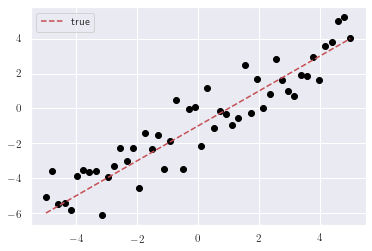

In [20]:
def model(x, weights):
    X = np.array([x**k for k in range(len(weights))]).transpose()
    return (X @ weights[:,np.newaxis]).flatten()

no_samples = 50

x = np.linspace(-5, 5, no_samples)

weights = np.array([-1, 1])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + np.random.normal(0, std_noise, len(y_true))

plt.plot(x, y_true, color='r', linestyle='--', label='true')
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.show()

### MCMC Sampling

One popular technique for approximating the intractable posterior is MCMC sampling, conrtary to other methods it makes no assumption concerning the form of the distribution, such as wether it can be approximated by a multivariate Gaussian. They only assume the posterior $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)$ can be calculated up to normalization constant $Z$ meaning $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)=\tilde{p}(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)/Z$, where $Z$ denotes the evidence in our case.

In general, sampling methods try to find the expectation of some function $\mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x})$ w.r.t. the posterior distribution for the model parameter:

$\mathbb{E}(\mathbf{f}) = \int \mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x}_*)p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)d\boldsymbol{\theta} ~.$

The integral in above equation is approximated using Monte Carlo sampling:

$\mathbb{E}(\mathbf{f}) = \frac{1}{M} \sum_{i=1}^M \mathbf{f}_{\boldsymbol{\theta}_i}(\mathbf{x}_i) \quad \textrm{where} \quad \boldsymbol{\theta}_i \sim p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2) ~.$

Similar, the variance can be denoted by

$\textrm{Var}[\mathbf{f}] = \frac{1}{M} \mathbb{E}[(\mathbf{f}-\mathbb{E}[\mathbf{f}])^2] ~,$

if the generated samples from the posterior $\boldsymbol{\theta}_i$ are independent. For complicated posterior distributions this is mostly impossible, but it still gives an unbiased estimate, if the number of generated samples is high enough.

To generate a set of dependent weights θi a Markov chain can be utilized that has
the posterior $p(\boldsymbol{\theta}|\mathbf{X},\mathbf{y},\sigma^2)$ as its equilibrium distribution. Markov Chains are a sequence of events, where the probability of one event depends only on the state of the previous one. So, one
samples from a proposal distribution $q(\boldsymbol{\theta}|\boldsymbol{\theta}_i)$ and maintains a record of the current state $\boldsymbol{\theta}_i$. A Markov chain is defined by giving an initial distribution for the
first state of the chain $\boldsymbol{\theta}_1$ and a transition distribution for a new state $\boldsymbol{\theta}_{i+1}$ following from the current state $\boldsymbol{\theta}_i$. A stationary distribution q is established if the distribution
given by state $\boldsymbol{\theta}_{i+1}$ is the same as with state $\boldsymbol{\theta}_i$. If the drawn samples are dependent then early drawn samples need to be discarded, since they usually are not representatives
of the equilibrium distribution referred to as burn in phase. If the samples are dependent
the chain also needs much longer to reach its equilibrium distribution.

A popular algorithm for MCMC sampling is Metropolis-Hastings. The acceptance probability Ai at time step i is given by

$A_i(\boldsymbol{\theta}_*,\boldsymbol{\theta}_i) = \textrm{min} \left( 1, \frac{q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_*)\tilde{p}(\boldsymbol{\theta}_*)}{q(\boldsymbol{\theta}_*|\boldsymbol{\theta}_i)\tilde{p}(\boldsymbol{\theta}_i)}  \right) ~,$

where $\boldsymbol{\theta}_i$ denotes the current state and $\boldsymbol{\theta}_*$ the drawn proposal state, $\tilde{p}(\boldsymbol{\theta})$ is the prior of the model parameters. The normalization constants cancel out each other. After the acceptance probability is calculated, a random number $r$ is drawn from a Uniform distribution $r \sim \mathcal{U}(0,1)$. If $A_i > r$ the proposal state is accepted. 

In [11]:
class MCMC:
    def __init__(self, start_params: np.ndarray, model: Callable, num_iter: int = 10000, burnin_iter: int = 5000):
        self.num_iter = num_iter
        self.burnin_iter = burnin_iter
        self.start_params = start_params
        self.model = model
    
    def proposal_fct(self, params, scale_weights=0.5, scale_std_noise=0.5):
        if isinstance(scale_weights, (float, int)):
            scale_weights = [scale_weights for _ in range(len(params)-1)]
        return np.append(np.random.normal(loc=params[:-1], scale=scale_weights), np.random.normal(loc=params[-1], scale=scale_std_noise))
    
    def metropolis_hastings(self, x, y):
        self.chain = np.zeros((self.num_iter, len(self.start_params)))
        self.chain[0] = self.start_params
        
        log_post = lambda p: self.log_posterior(x, y, p, self.model)

        for i in tqdm(range(self.num_iter-1)):
            proposal = self.proposal_fct(self.chain[i])
            posterior_prob = np.exp(log_post(proposal) - log_post(self.chain[i]))
            if np.random.uniform(0, 1) < posterior_prob:
                self.chain[i+1] = proposal
            else:
                self.chain[i+1] = self.chain[i]

        self.posterior_params = self.chain[self.burnin_iter:].mean(axis=0)
        
        return self.posterior_params
    
    def posterior_pred(self, x):
        y_pred = np.array([self.model(x, c[:-1]) for c in self.chain[self.burnin_iter:]])
        return y_pred.mean(axis=0).flatten(), y_pred.std(axis=0).flatten()
    
    @staticmethod
    def log_prior(params, prior_scale_weights=1., prior_scale_noise=5.):
        if isinstance(prior_scale_weights, (float, int)):
            prior_scale_weights = [prior_scale_weights for _ in range(len(params)-1)]
        log_prior_weights = np.array([stats.norm.logpdf(w, loc=0, scale=psw) for w, psw in zip(params[:-1], prior_scale_weights)])
        log_prior_noise = stats.uniform.logpdf(params[-1], loc=0, scale=prior_scale_noise)
        return log_prior_weights.sum() + log_prior_noise
    
    @staticmethod
    def log_likelihood(x, y, params, model):
        y_pred = model(x, params[:-1])
        log_likelihoods = stats.norm.logpdf(y, loc=y_pred, scale=params[-1])
        return np.sum(log_likelihoods)
    
    def log_posterior(self, x, y, params, model):
        return self.log_likelihood(x, y, params, model) + self.log_prior(params)

### Variational Inference



In [12]:
class VI:
    def __init__(self, num_iter: int = 100, start_alpha: float = 0.1, start_beta: float = 0.1,
                alpha_a_prior: float = 10**(-3), alpha_b_prior: float = 10**3,
                beta_c_prior: float = 10**(-2), beta_d_prior: float = 10**2):
        self.alpha_a_prior = alpha_a_prior
        self.alpha_b_prior = alpha_b_prior
        self.beta_c_prior = beta_c_prior
        self.beta_d_prior = beta_d_prior

        self.alpha = start_alpha
        self.beta = start_beta

        self.num_iter = num_iter
    
    def inference(self, x, y, pol_grad: int = 1):
        self.D = pol_grad + 1
        N = len(y)
        X = np.array([x**k for k in range(self.D)]).transpose()
        
        alpha_a = self.alpha_a_prior + self.D/2 
        beta_c = self.beta_c_prior + N/2
        
        for i in tqdm(range(self.num_iter)):
            self.w_cov = np.linalg.inv(self.beta * X.T @ X + self.alpha * np.eye(self.D))

            self.w_mean = self.beta * self.w_cov @ X.T @ y

            beta_d = self.beta_d_prior + 0.5 * ((y - X @ self.w_mean) ** 2).mean() + 0.5 * self.alpha * self.w_mean.T @ self.w_mean
            self.beta = beta_c/beta_d

            alpha_b = self.alpha_b_prior + 0.5 * (self.beta * self.w_mean.T @ self.w_mean + np.trace(self.w_cov))
            self.alpha = alpha_a/alpha_b
        
        self.x_var = (1/self.beta) + X @ self.w_cov @ X.T
        
        return self.w_mean, self.w_cov
    
    def posterior_pred(self, x_pred):
        X = np.array([x_pred**k for k in range(self.D)]).transpose()
        preds = []
        for _ in range(100):
            weight_sample = np.random.multivariate_normal(self.w_mean, self.w_cov)
            pred = X @ weight_sample[:,np.newaxis]
            preds.append(pred)
        preds = np.array(preds)
        return preds.mean(axis=0).flatten(), preds.std(axis=0).flatten()

In [13]:
start_params_mcmc = np.array([0.5, 0.5, 0.5])
mcmc = MCMC(start_params=start_params_mcmc, model=model)
posterior_params_mcmc = mcmc.metropolis_hastings(x, y_noisy)

100%|██████████| 9999/9999 [00:13<00:00, 730.09it/s]


In [14]:
vi = VI()
w_mean_vi, w_cov_vi = vi.inference(x, y_noisy)

100%|██████████| 100/100 [00:00<00:00, 6377.13it/s]


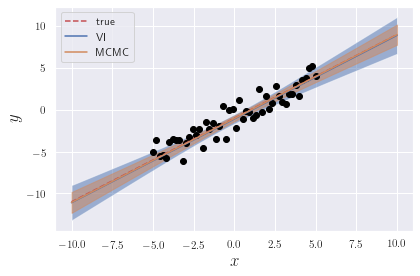

In [22]:
x_pred = np.linspace(-10, 10, 1000)

y_true_pred = model(x_pred, weights)

y_pred_mcmc_mean, y_pred_mcmc_std = mcmc.posterior_pred(x_pred)
y_pred_vi_mean, y_pred_vi_std = vi.posterior_pred(x_pred)

plt.plot(x_pred, y_true_pred, color='r', linestyle='--', label='true')
plt.plot(x_pred, y_pred_vi_mean, label='VI')
plt.fill_between(x_pred, y_pred_vi_mean + 2 * y_pred_vi_std, y_pred_vi_mean - 2 * y_pred_vi_std, alpha=0.5)
plt.plot(x_pred, y_pred_mcmc_mean, label='MCMC', color='#D1895C')
plt.fill_between(x_pred, y_pred_mcmc_mean + 2 * y_pred_mcmc_std, y_pred_mcmc_mean - 2 * y_pred_mcmc_std, color='#D1895C', alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.xlabel(r'$x$', fontsize=17)
plt.ylabel(r'$y$', fontsize=17)
plt.tight_layout()
plt.savefig('reg_mcmc_vi.png')
plt.show()

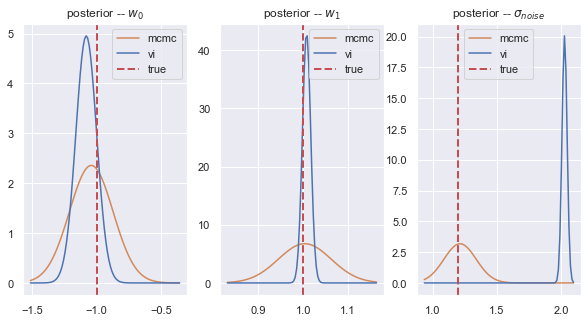

In [16]:
fig, axs = plt.subplots(1, mcmc.chain.shape[1], figsize=(10,5))
for i, ax in enumerate(axs):
    # mcmc
    samples = mcmc.chain[mcmc.burnin_iter-1:,i]
    x = np.linspace(samples.min(), samples.max(), 100)
    
    mu_mcmc, std_mcmc = stats.norm.fit(samples)
    #ax.hist(x, bins=20)
    #ax.plot(x, stats.norm.pdf(x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
    #ax.axvline(x.mean(), color='#D1895C', linestyle='--', linewidth=2, label='mean')
    
    # true params
    if i != len(axs)-1:
        # mcmc
        ax.plot(x, stats.norm.pdf(x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(x, stats.norm.pdf(x, vi.w_mean[i], vi.w_cov[i,i]), label='vi')
        ax.axvline(weights[i], color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $w_%d$' % i)
    else:
        vi_std_mean = np.sqrt(vi.x_var.mean())
        vi_std_std = np.sqrt(vi.x_var).std()
        new_x = np.linspace(x.min(), vi_std_mean+3.5*vi_std_std, 100)
        # mcmc
        ax.plot(new_x, stats.norm.pdf(new_x, mu_mcmc, std_mcmc), label='mcmc', color='#D1895C')
        # vi
        ax.plot(new_x, stats.norm.pdf(new_x, vi_std_mean, vi_std_std), label='vi')

        ax.axvline(std_noise, color='r', linestyle='--', linewidth=2, label='true')
        ax.title.set_text(r'posterior -- $\sigma_{noise}$')
    ax.legend()
plt.show()